In [1]:
import multiprocessing as mp
import matplotlib.pyplot as plt
import sklearn.neighbors as NN
from scipy.sparse.linalg import cg
import numpy as np
import math
%matplotlib widget

In [2]:
def make_particles():
    length =1 # meters
    dp = 0.008 # meters
    # length =1 # meters
    # dp = 0.008 # meters
    boundary_width = dp*40 # meters
    x1 = -length/2 - boundary_width/2
    x2 = length/2 + boundary_width/2
    y1 = -length/2 - boundary_width/2
    y2 = length/2 + boundary_width/2
    resolution = int((length+boundary_width)/dp)
    positions = np.zeros((resolution**2,2))
    density = np.ones(resolution**2)
    density = density * 1000
    velocity = np.zeros((resolution**2,2))
    mass = density[1]*dp**2
    type = np.zeros(resolution**2)
    count = 0
    for i in range(resolution):
        for j in range(resolution):
            positions[count] = np.array([(x1+(dp*i)),(y1+(dp*j))])
            if x1+boundary_width/2<(x1+(dp*i))<x2-dp-boundary_width/2 and y1+boundary_width/2<(y1+(dp*j))<y2-dp-boundary_width/2:
                type[count] = 1
            count += 1
    
    h = 0.02 
    kh = h*2
    temp = ((resolution*resolution/2 ))    
    # temp = temp + ((resolution )*2)
    temp = int(temp)
    return positions, velocity, density, mass, type, kh, h, temp

In [3]:
def poly6(kh, distance):
    h = kh/2
    h1 = 1/h
    q = distance * h1
    fac = (4*h1**8)/(np.pi)
    temp = h**2 - distance**2
    if 0 < distance < h:
        return fac * (temp)**3
    else:
        return 0

In [4]:
def get_fac_w(h1):
    # get the kernel normalizing factor
    fac = 7/(4*np.pi)
    fac = fac * h1 * h1
    return fac

def ker_w(kh,distance):
    h = kh/2
    h1 = 1/h
    q = distance * h1
    temp = 1 - 0.5 * q
    fac = get_fac_w(h1)
    if q <= 2 and q>0:
        return (fac * temp * temp * temp *temp *(2*q +1))
    else:
        return 0

In [5]:
def get_fac_cs(h1):
    # get the kernel normalizing factor
    fac = 10/(7 * np.pi)
    fac = fac * h1 * h1
    return fac

# Cubic spline kernel
def ker_cs(kh,distance):
    h = kh/2
    h1 = 1/h
    q = distance * h1
    fac = get_fac_cs(h1)
    tmp2 = 2. - q
    if q <=0:
        val = 0
    elif (q > 2.0):
        val = 0.0
    elif (q > 1.0):
        val = 0.25 * tmp2 * tmp2 * tmp2
    else:
        val = 1 - 1.5 * q * q * (1 - 0.5 * q)
    return val * fac

In [6]:
def check_kernel_summation_for_particle(arg):
    i, positions, kh, NN_idx,mass, density= arg
    den = np.zeros(3)
    for j in NN_idx[i]:
        r_ij = positions[i] - positions[j]
        distance = np.linalg.norm(r_ij)
        if distance <= kh and distance > 0.0:
            weight = poly6(kh, distance)
            den[0] += weight *mass
            weight = ker_w(kh, distance)
            den[1] += weight *mass
            weight = ker_cs(kh, distance)
            den[2] += weight *mass

            # den += weight *distance/(distance+1e-20)
    return i, den

In [7]:
def plot_prop(positions, prop, title, climax=None, climin=None):
    plt.clf()
    plt.scatter(positions[:,0], positions[:,1], c=prop, cmap='viridis', s=2)
    if climax is not None:
        plt.clim(vmax=climax, vmin=climin)
    plt.colorbar()
    plt.savefig(f'{title}.png')

In [8]:
pos, vel, density, mass, type, kh, h, mid = make_particles()
Eta = 1e-20
radius_ = 4*kh
nbrs = NN.NearestNeighbors(radius=radius_, algorithm='kd_tree').fit(pos)
NN_idx = nbrs.radius_neighbors(pos)[1]
print(f'average number of neighbors: {np.mean([len(idx) for idx in NN_idx])}')
h_vals = np.linspace(1.5*h, radius_, 1000)
ker_vals = np.zeros((len(h_vals), 3))

average number of neighbors: 1125.5963636363635


In [9]:
for i, h_val in enumerate(h_vals):
        kh_ = h_val
        arg =(mid, pos, kh_, NN_idx, mass, density)
        _, ker_vals[i,:] = check_kernel_summation_for_particle(arg)

In [10]:
loc_tol = np.zeros(3)

loc_tol[0] = int((np.argwhere(ker_vals[:,0] > 900)[0][0]))
loc_tol[1] = int((np.argwhere(ker_vals[:,1] > 900)[0][0]))
loc_tol[2] = int((np.argwhere(ker_vals[:,2] > 900)[0][0]))
loc_tol = loc_tol.astype(int)
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600


In [11]:
def plot_NN_grp(positions, NN_idx, title, mid, h_vals, pos, loc_tol, ker_vals):
    plt.cla()
    x1 = np.min(positions[:,0])
    x2 = np.max(positions[:,0])
    y1 = np.min(positions[:,1])
    y2 = np.max(positions[:,1])
    r_min = np.min(h_vals)
    r_max = np.max(h_vals)
        # Plotting the square
    idx = 0
    for k in NN_idx[mid]:
        distance = np.linalg.norm(pos[k] - pos[mid])
        if distance == 0:
            idx = k
            break
    circle1 = plt.Circle((pos[idx,0], pos[idx,1]), h_vals[0], color='k', fill=False)
    circle_poly = plt.Circle((pos[idx,0], pos[idx,1]), h_vals[loc_tol[0]], color='r',linestyle = '--', fill=False)
    circle_w = plt.Circle((pos[idx,0], pos[idx,1]), h_vals[loc_tol[1]], color='b', linestyle = '--', fill=False)
    circle_cs = plt.Circle((pos[idx,0], pos[idx,1]), h_vals[loc_tol[2]], color='g', linestyle = '--', fill=False)
    # circle2 = plt.Circle((pos[idx,0], pos[idx,1]), r_max, color='r', fill=False)
    # plt.figure(figsize=(8, 8))
    plt.plot([x1, x2], [y1, y1], 'k-')  # bottom
    plt.plot([x1, x2], [y2, y2], 'k-')  # top
    plt.plot([x1, x1], [y1, y2], 'k-')  # left
    plt.plot([x2, x2], [y1, y2], 'k-')  # right

    # Plotting the circles
    
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle_poly)
    plt.gca().add_patch(circle_w)
    plt.gca().add_patch(circle_cs)
    # plt.gca().add_patch(circle2)

    plt.xlim(x1 - r_max, x2 + r_max)
    plt.ylim(y1 - r_max, y2 + r_max)

    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.scatter(positions[NN_idx[mid][:],0], positions[NN_idx[mid][:],1], s=2)
    plt.xlim(-0.7, 0.7)
    plt.ylim(-0.7, 0.7)
    # plt.show()
    plt.savefig(f'NN_grp_{title}.png')

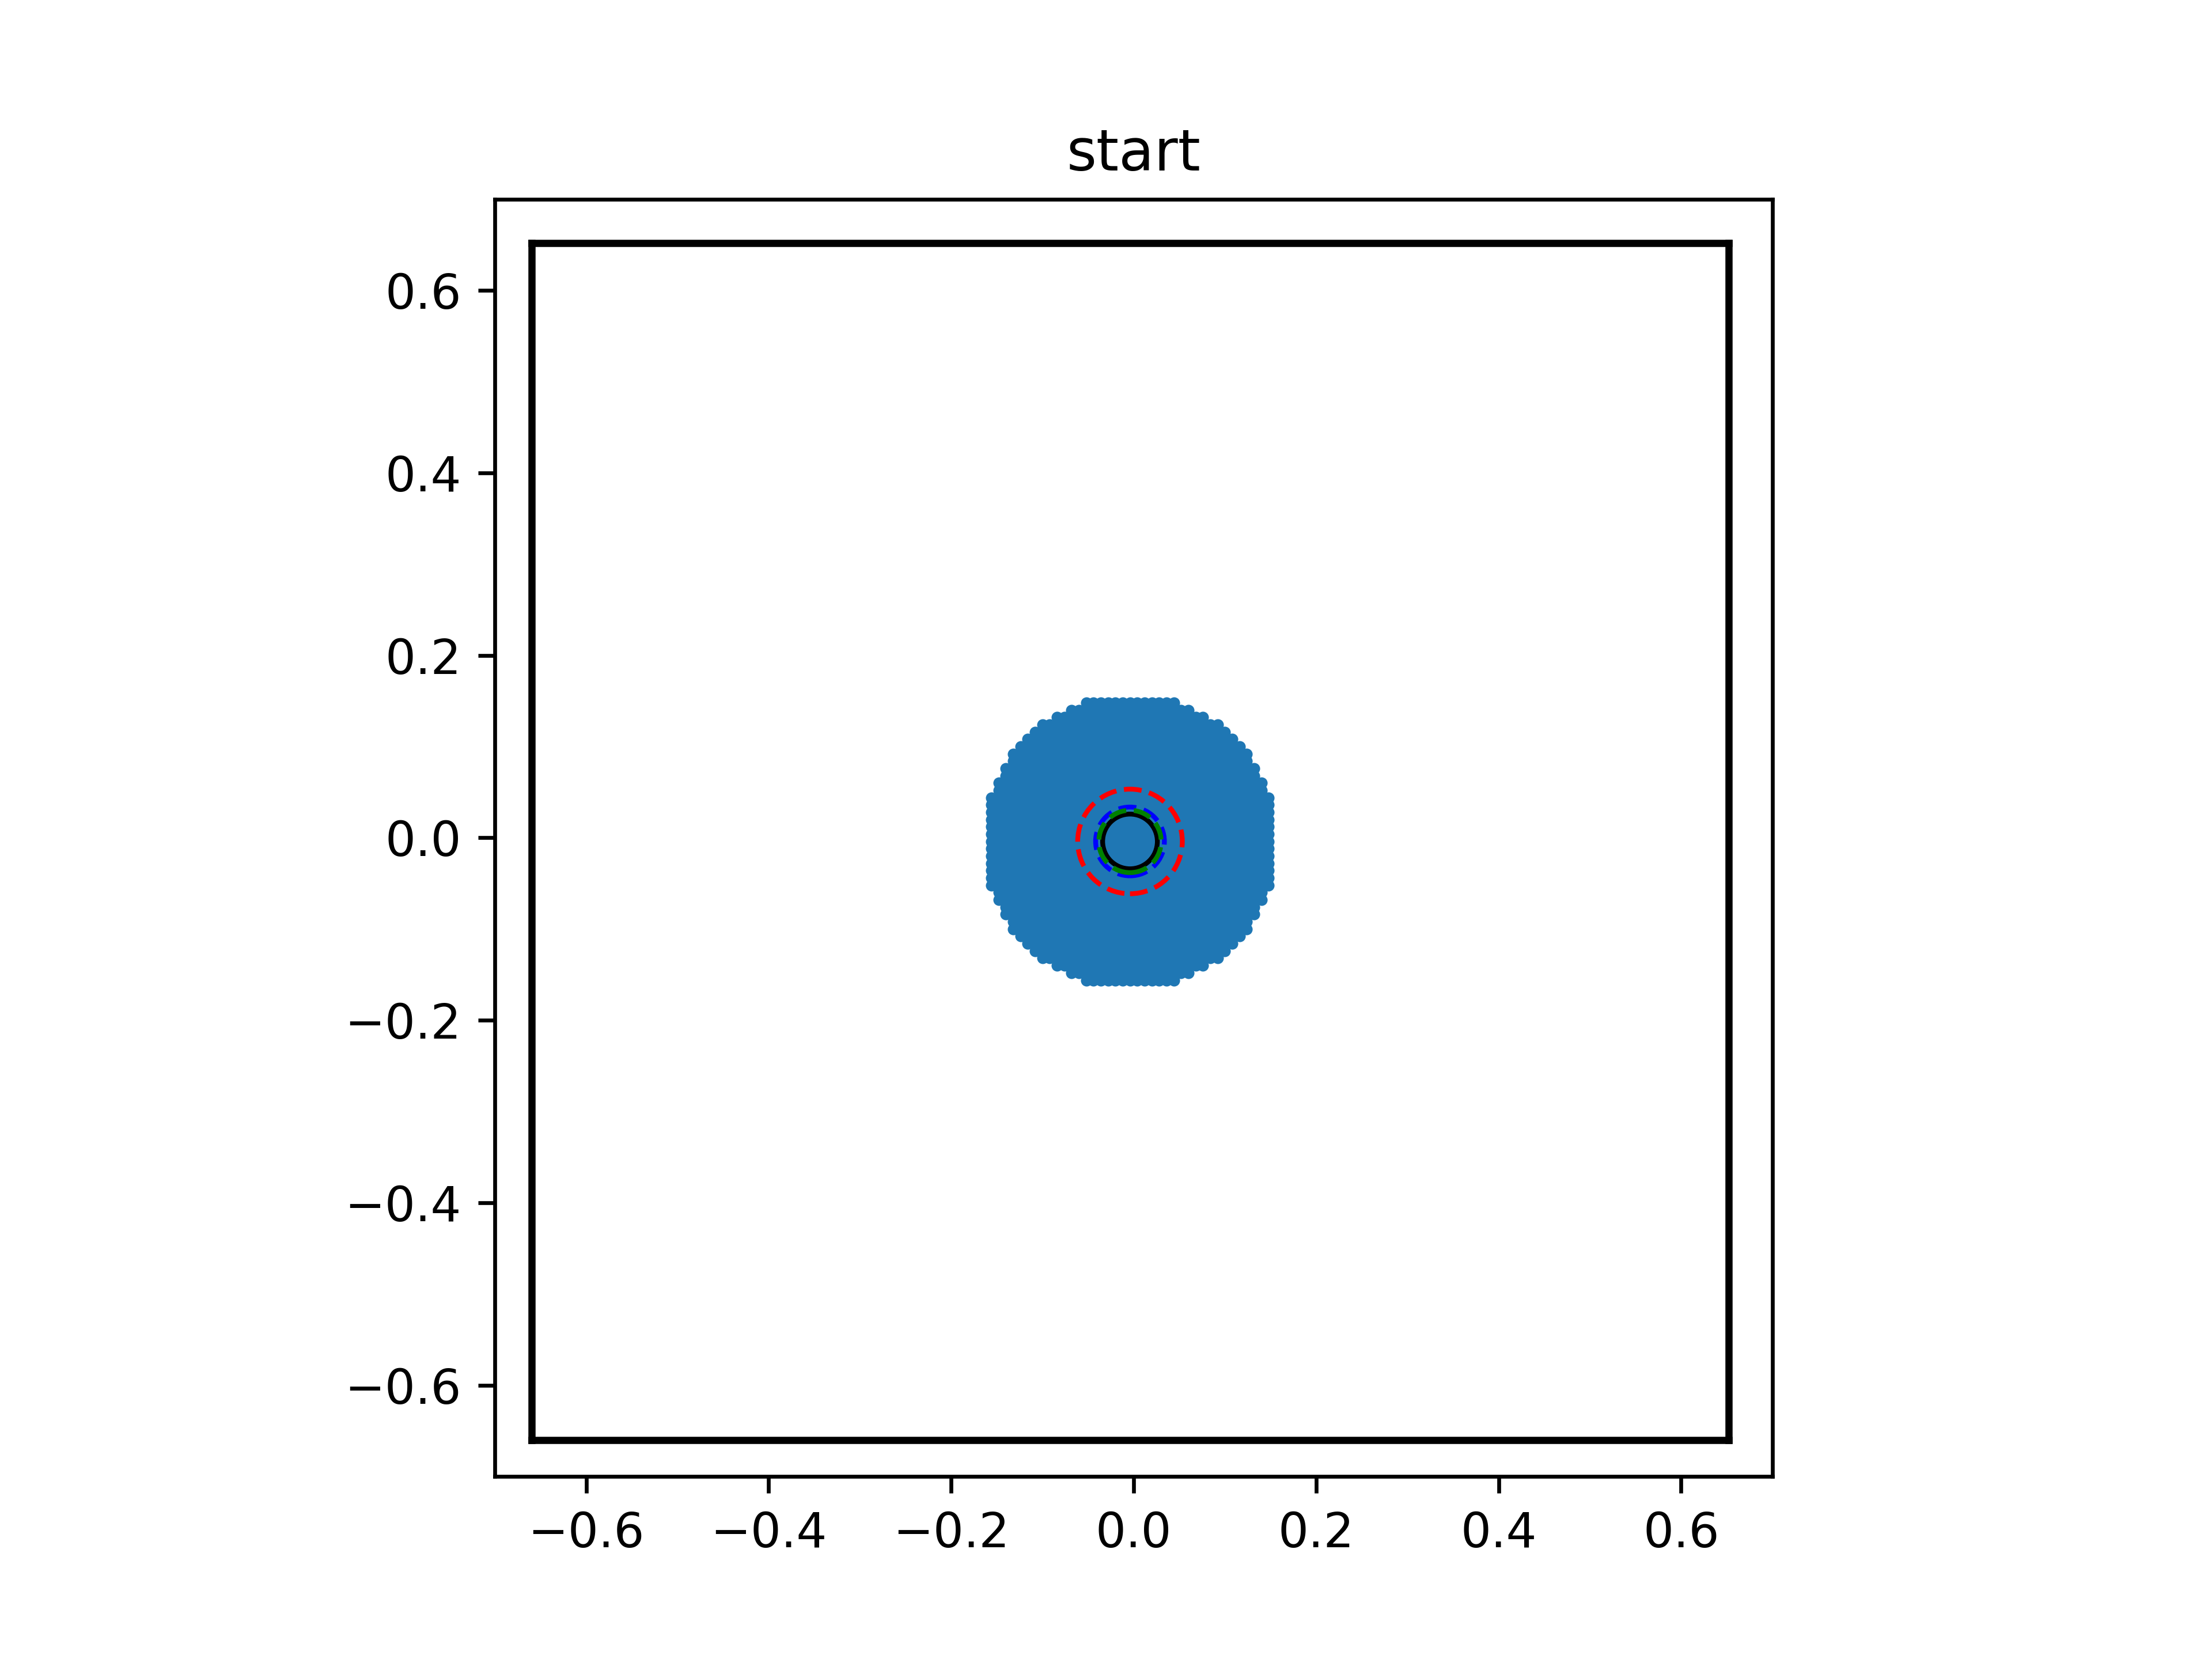

In [12]:
plot_NN_grp(pos, NN_idx, 'start', mid, h_vals, pos, loc_tol, ker_vals)

In [ ]:

plt.cla()
fac = 0.008
plt.plot(h_vals/fac, (1000-ker_vals[:,0])/10, 'r', label = 'Poly6') 
plt.plot(h_vals/fac, (1000-ker_vals[:,1])/10, 'b', label = 'Wendland' ) 
plt.plot(h_vals/fac, (1000-ker_vals[:,2])/10, 'g', label = 'Cubic spline' ) 
min = np.max(1000-ker_vals[:,0])
plt.plot([2*h/fac,2*h/fac], [0,min/10],'k--', label='DSPH_default')
plt.plot([h_vals[loc_tol[0]]/fac,h_vals[loc_tol[0]]/fac], [0,min/10],'r--')
plt.plot([h_vals[loc_tol[1]]/fac,h_vals[loc_tol[1]]/fac], [0,min/10],'b--')
plt.plot([h_vals[loc_tol[2]]/fac,h_vals[loc_tol[2]]/fac], [0,min/10],'g--')
# plt.ylim(0,1)
# plt.plot([2*h/fac,2*h/fac], [0,100],'k--', label='DSPH_default')
plt.xlabel('kh (factor of dp)')
plt.ylabel('Density, reference density = 1000')
plt.grid(b='True', which = 'major', linestyle = '-')
plt.grid(b='True', which = 'minor', linestyle = '--', alpha = 0.5)
# plt.yscale('log')
plt.gca().set_aspect('auto', adjustable='box')
plt.legend(loc = 'upper right')
plt.savefig('ker_vals.png')

# ker_calc = check_kernel_summation(pos, kh, NN_idx)
# plot_prop(pos, ker_calc, 'ker_calc')